In [3]:
!pip install POT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.4/835.4 kB 18.5 MB/s eta 0:00:00


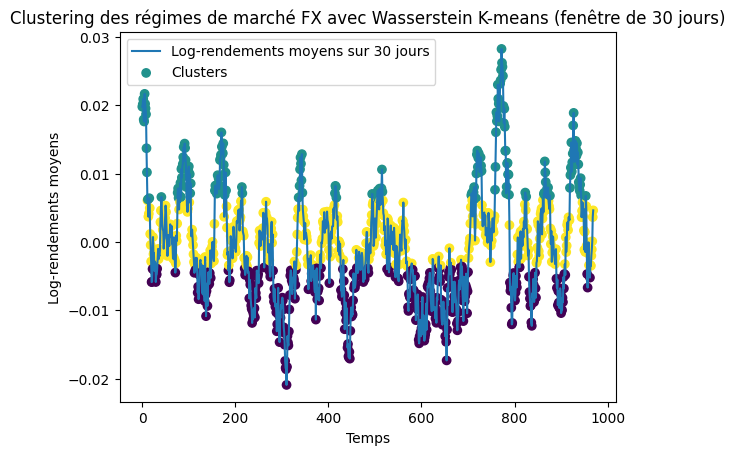

In [15]:
# Importation des bibliothèques nécessaires
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.cluster import KMeans
from ot import emd2  # Pour le calcul de la distance de Wasserstein
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

# Chargement des données et calcul des log-rendements sur une fenêtre de 30 jours
def load_data(window=30):
    prix_fx = np.random.normal(1, 0.05, 1000).cumprod()  # Génère une série de prix
    log_returns = np.diff(np.log(prix_fx))  # Calcul des log-rendements instantanés

    # Calcul des log-rendements moyens sur des fenêtres de 30 jours
    windowed_log_returns = np.array([
        np.mean(log_returns[i:i+window]) for i in range(len(log_returns) - window + 1)
    ])

    return windowed_log_returns

# Chargement des données et calcul des log-rendements instantanés (1 jour)
#def load_data():
#    prix_fx = np.random.normal(1, 0.05, 1000).cumprod()  # Génère une série de prix
#    log_returns = np.diff(np.log(prix_fx))  # Calcul des log-rendements instantanés (1 jour)
#    return log_returns

# Fonction de calcul de la distance de Wasserstein entre distributions de log-rendements
def wasserstein_distance_matrix(data):
    n = len(data)
    W_distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            W_distances[i, j] = emd2(data[i].reshape(-1, 1), data[j].reshape(-1, 1))
            W_distances[j, i] = W_distances[i, j]
    return W_distances

# Implémentation de l'algorithme Wasserstein K-means
class WassersteinKMeans:
    def __init__(self, n_clusters, max_iter=100, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = None

    def fit(self, data):
        # Initialisation des clusters avec KMeans classique pour obtenir les premiers centroids
        kmeans = KMeans(n_clusters=self.n_clusters)
        labels = kmeans.fit_predict(data)
        self.centroids = [self.compute_wasserstein_barycenter(data[labels == k]) for k in range(self.n_clusters)]

        for iteration in range(self.max_iter):
            # Calcul des barycentres Wasserstein pour chaque cluster
            new_centroids = []
            for k in range(self.n_clusters):
                cluster_points = data[labels == k]
                if len(cluster_points) > 0:
                    centroid = self.compute_wasserstein_barycenter(cluster_points)
                    new_centroids.append(centroid)
                else:
                    new_centroids.append(self.centroids[k])  # Garde l'ancien centre si le cluster est vide

            new_centroids = np.array(new_centroids)

            # Vérification de la convergence
            shift = np.sum([wasserstein_distance(self.centroids[i], new_centroids[i]) for i in range(self.n_clusters)])
            if shift < self.tol:
                break
            self.centroids = new_centroids
            # Réassignation des labels en fonction des nouvelles distances Wasserstein
            labels = np.array([np.argmin([wasserstein_distance(data[i], self.centroids[j]) for j in range(self.n_clusters)]) for i in range(len(data))])

        return labels

    def compute_wasserstein_barycenter(self, distributions):
        # Fonction simplifiée pour le barycentre Wasserstein
        return np.mean(distributions, axis=0)

# Exécution de l'algorithme avec la série de log-rendements moyennés
log_returns = load_data(window=30)
wasserstein_kmeans = WassersteinKMeans(n_clusters=3)
labels = wasserstein_kmeans.fit(log_returns.reshape(-1, 1))

# Visualisation des résultats
plt.plot(log_returns, label="Log-rendements moyens sur 30 jours")
plt.scatter(range(len(log_returns)), log_returns, c=labels, cmap='viridis', label="Clusters")
plt.xlabel("Temps")
plt.ylabel("Log-rendements moyens")
plt.title("Clustering des régimes de marché FX avec Wasserstein K-means (fenêtre de 30 jours)")
plt.legend()
plt.show()

# Exécution de l'algorithme avec la série de log-rendements journaliers
#log_returns = load_data()
#wasserstein_kmeans = WassersteinKMeans(n_clusters=3)
#labels = wasserstein_kmeans.fit(log_returns.reshape(-1, 1))

# Visualisation des résultats
#plt.plot(log_returns, label="Log-rendements journaliers")
#plt.scatter(range(len(log_returns)), log_returns, c=labels, cmap='viridis', label="Clusters")
#plt.xlabel("Temps")
#plt.ylabel("Log-rendements")
#plt.title("Clustering des régimes de marché FX avec Wasserstein K-means (1 jour)")
#plt.legend()
#plt.show()
